In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import et aperçu des datasets

df_continents = pd.read_csv('continents2.csv')
display(df_continents.head())

name alpha-2 alpha-3  country-code     iso_3166-2   region  \
0     Afghanistan      AF     AFG             4  ISO 3166-2:AF     Asia   
1   Åland Islands      AX     ALA           248  ISO 3166-2:AX   Europe   
2         Albania      AL     ALB             8  ISO 3166-2:AL   Europe   
3         Algeria      DZ     DZA            12  ISO 3166-2:DZ   Africa   
4  American Samoa      AS     ASM            16  ISO 3166-2:AS  Oceania   

        sub-region intermediate-region  region-code  sub-region-code  \
0    Southern Asia                 NaN        142.0             34.0   
1  Northern Europe                 NaN        150.0            154.0   
2  Southern Europe                 NaN        150.0             39.0   
3  Northern Africa                 NaN          2.0             15.0   
4        Polynesia                 NaN          9.0             61.0   

   intermediate-region-code  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN

In [4]:
df_2024_Table = pd.read_excel('DataForTable2.1.xls')
display(df_2024_Table.head())

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008     3.723590            7.350416        0.450662   
1  Afghanistan  2009     4.401778            7.508646        0.552308   
2  Afghanistan  2010     4.758381            7.613900        0.539075   
3  Afghanistan  2011     3.831719            7.581259        0.521104   
4  Afghanistan  2012     3.782938            7.660506        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         50.500000                      0.718114    0.164055   
1                         50.799999                      0.678896    0.187297   
2                         51.099998                      0.600127    0.117861   
3                         51.400002                      0.495901    0.160098   
4                         51.700001                      0.530935    0.234157   

   Perceptions of corruption  Positive affect  Negative affect  
0                   0.881686         0.414297         0.258195  
1                   0.850035         0.481421         0.237092  
2                   0.706766         0.516907         0.275324  
3                   0.731109         0.479835         0.267175  
4                   0.775620         0.613513         0.267919

## Nettoyage des données

In [5]:
# Correspondance des noms de pays
df_2024_Table['Country name'] = df_2024_Table['Country name'].replace({'Türkiye':'Turkey',
                                                                       'Taiwan Province of China':'Taiwan',
                                                                       'Hong Kong S.A.R. of China':'Hong Kong'
                                                                       })

df_continents['name'] = df_continents['name'].replace({'Bosnia And Herzegovina':'Bosnia and Herzegovina',
                                                       'Congo (Democratic Republic Of The)':'Congo (Brazzaville)',
                                                       'Congo':'Congo (Kinshasa)',
                                                       "Côte D'Ivoire":'Ivory Coast',
                                                       'Czech Republic':'Czechia',
                                                       'Macedonia':'North Macedonia',
                                                       'Palestine, State of':'State of Palestine'
                                                       })

# Merge des 2 datasets
df_2024 = pd.merge(df_2024_Table, df_continents[['name', 'region','sub-region']], left_on = "Country name", right_on = "name", how = 'left')

# Drop colonne "name"
df_2024.drop(columns='name', inplace=True)

# Ordre et casse des colonnes
df_2024 = df_2024[['Country name', 'region', 'sub-region'] + [col for col in df_2024.columns if col not in ['Country name', 'region', 'sub-region']]]

df_2024 = df_2024.rename(columns={'region': 'Region', 'sub-region': 'Sub region', 'year': 'Year'})

# Ajout données Kosovo
df_2024.loc[df_2024['Country name'] == 'Kosovo', ['Region', 'Sub region']] = ['Europe', 'Southern Europe']

# Conservation des 10 dernières années 
df_2024 = df_2024.drop(df_2024[df_2024.Year < 2014].index)

In [6]:
df_2024.isna().sum()

Country name                         0
Region                               0
Sub region                           0
Year                                 0
Life Ladder                          0
Log GDP per capita                  22
Social support                       5
Healthy life expectancy at birth    35
Freedom to make life choices        20
Generosity                          30
Perceptions of corruption           77
Positive affect                     10
Negative affect                      9
dtype: int64

## Visualisation

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### Pairplot

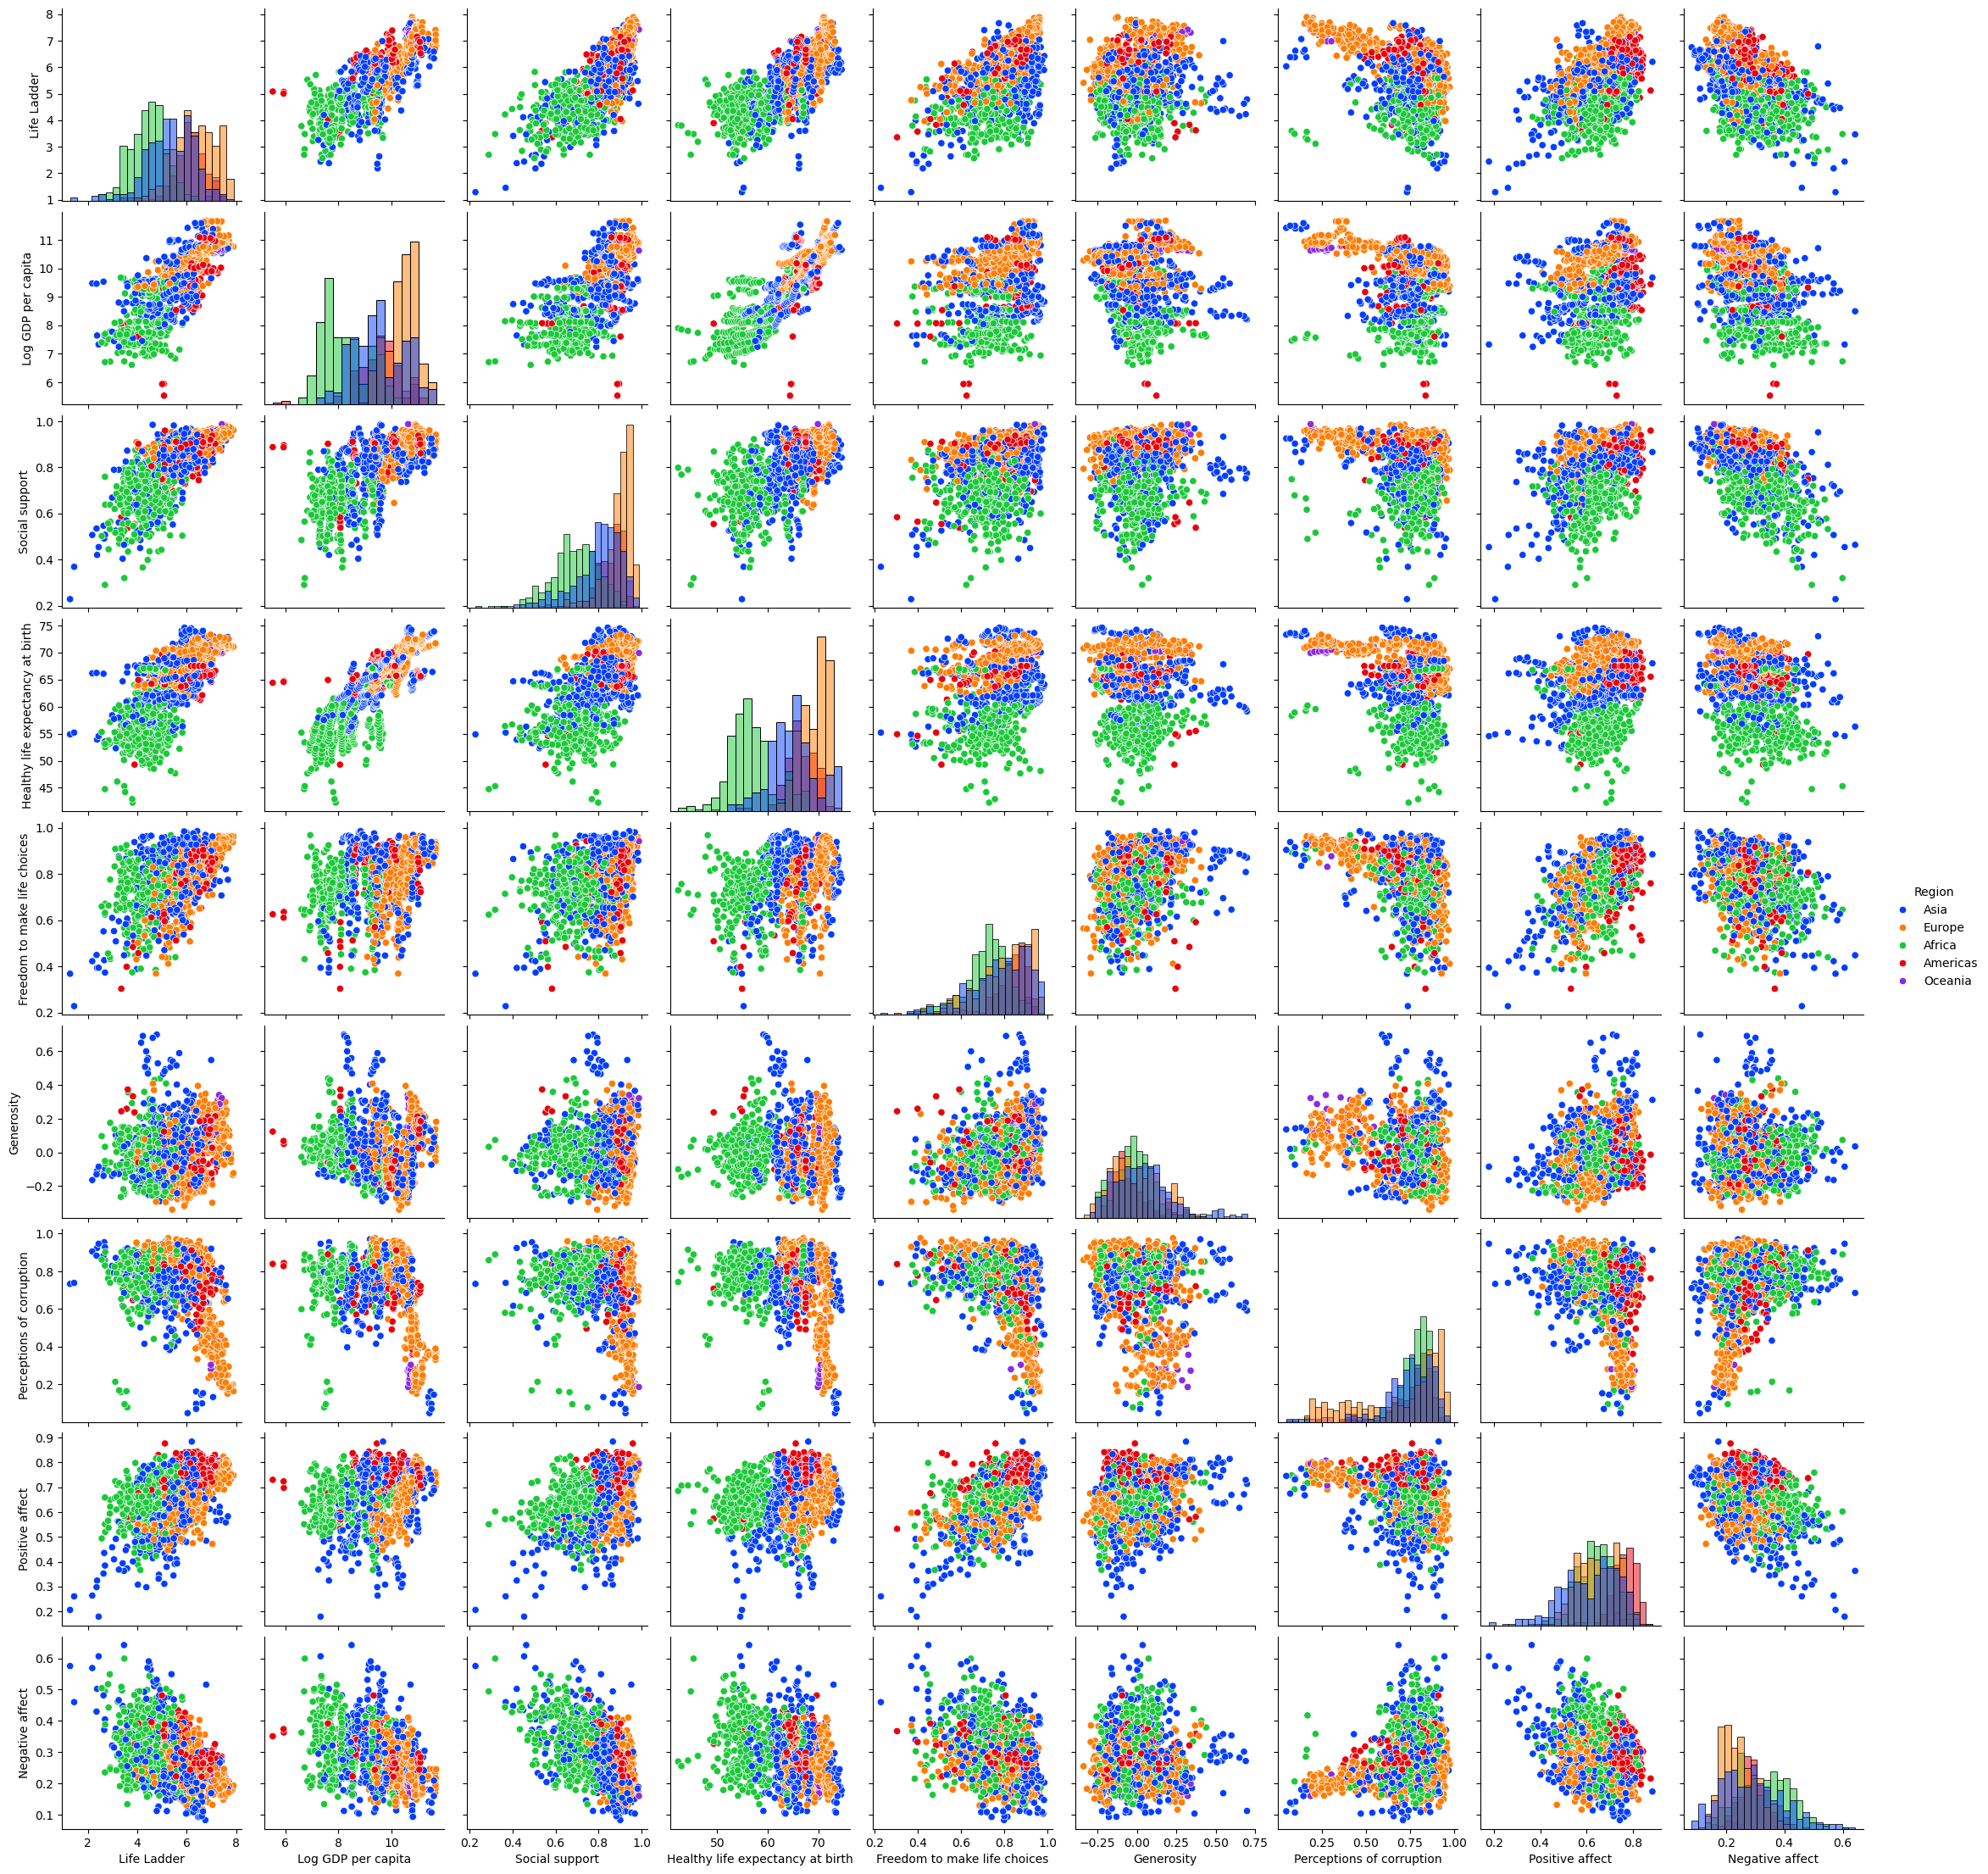

In [8]:
sns.pairplot(data = df_2024.drop(columns = 'Year'), diag_kind = 'hist', hue = 'Region', palette ='bright')

#### Heatmap

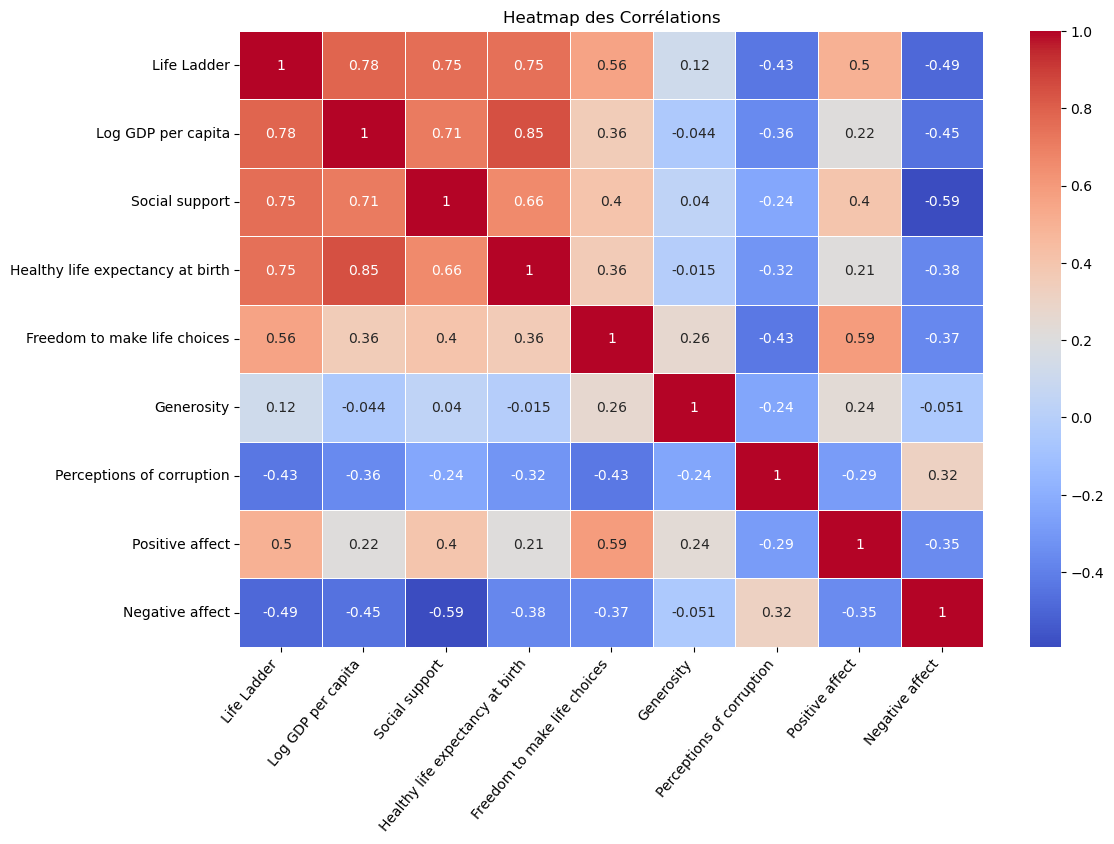

In [9]:
def conv_float(colonne):
    if df_2024[colonne].dtype == 'object':
        df_2024[colonne] = df_2024[colonne].str.replace(',', '.').astype(float)

colonnes_a_convertir = ['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                        'Freedom to make life choices', 'Generosity','Perceptions of corruption', 'Positive affect', 'Negative affect']


for colonne in colonnes_a_convertir:
    conv_float(colonne)


corr = df_2024[colonnes_a_convertir].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=50,ha='right')
plt.title('Heatmap des Corrélations')
plt.show()

#### Carte choroplèthe

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go

In [11]:
# On crée une carte avec des filtres pour les sous-région
fig = px.choropleth(df_2024,
                    locations='Country name',
                    locationmode='country names',
                    color='Life Ladder',
                    hover_name='Country name',
                    color_continuous_scale=px.colors.sequential.Magma,
                    title='Score de 2024 de Life Ladder par pays',
                    animation_frame='Sub region', # Ajout de l'animation pour les sous-régions
                    animation_group='Country name', # Ajout du groupe d'animation
                    )

# On ajoute les filtres pour les sous-régions via Plotly Dash
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="LightGray")

# On affiche la carte
fig.show()

#### Graphiques de dispersion

In [12]:
# Création du graphique de dispersion
fig = px.scatter(df_2024, 
                 x='Log GDP per capita', 
                 y='Life Ladder', 
                 color='Country name',
                 title='Relation entre le Log PIB par habitant et la Satisfaction de vie',
                 labels={'Log GDP per capita': 'Log PIB par habitant', 'Life Ladder': 'Satisfaction de vie'},
                 hover_data=['Country name'])

# Afficher le graphique
fig.show()

In [13]:
# On crée un nuage de points pour explorer les relations potentielles
fig = px.scatter(df_2024, x='Log GDP per capita', y='Life Ladder', color='Region',
                 title='Relation entre le Log PIB par habitant et Life Ladder',
                 labels={'Log GDP per capita': 'Log PIB par habitant', 'Life Ladder': 'Satisfaction de vie'},
                 hover_name='Country name')

# On affiche le graphique
fig.show()

#### Courbes

In [14]:
# Calculer la moyenne pour 'Freedom_to_make_life_choices' pour chaque pays
df_grouped = df_2024.groupby('Country name').agg({
    'Freedom to make life choices': 'mean'
}).reset_index()

# Trier et sélectionner les top 5 pays
df_top5 = df_grouped.sort_values(by='Freedom to make life choices', ascending=False).head(5)

# Filtrer les données originales pour les top 5 pays
df_top5_countries = df_2024[df_2024['Country name'].isin(df_top5['Country name'])]

# Transformer le DataFrame en format long pour Plotly
df_long = df_top5_countries.melt(id_vars=['Country name', 'Year'],
                                  value_vars=['Freedom to make life choices', 'Generosity', 'Perceptions of corruption'],
                                  var_name='Indicator',
                                  value_name='Value')

# Créer le graphique
fig = px.line(df_long, x='Year', y='Value', color='Indicator',
              facet_col='Country name', facet_col_wrap=2,
              title='Top 5 Countries Based on Freedom to Make Life Choices')

fig.show()

#### Histogramme

In [15]:
#Conversion des colonnes numériques en float
cols_to_convert = ['Life Ladder', 'Log GDP per capita', 'Social support', 
                   'Healthy life expectancy at birth', 'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']

df_2024[cols_to_convert] = df_2024[cols_to_convert].astype(float)

# Vérification des colonnes
print("Colonnes disponibles dans df_2024:", df_2024.columns)

# Calculer les moyennes par région, en ignorant les colonnes non numériques
df_mean = df_2024.groupby('Region')[cols_to_convert].mean().reset_index()

# Vérification des colonnes après la transformation
print("Colonnes disponibles dans df_2024:", df_mean.columns)

# Transformation des données pour une visualisation avec plotly.express
df_long = df_mean.melt(id_vars=['Region'], 
                       value_vars=cols_to_convert,
                       var_name='Variable', 
                       value_name='Value')

# Créer un graphique en barres empilées pour comparer les valeurs moyennes
fig = px.bar(df_long, x='Region', y='Value', color='Variable', barmode='group',
             title='Comparaison des valeurs moyennes par région',
             labels={'Value': 'Valeur moyenne', 'Variable': 'Facteur'})

# Afficher le graphique
fig.show()

Colonnes disponibles dans df_2024: Index(['Country name', 'Region', 'Sub region', 'Year', 'Life Ladder',
       'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption', 'Positive affect',
       'Negative affect'],
      dtype='object')
Colonnes disponibles dans df_2024: Index(['Region', 'Life Ladder', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption'],
      dtype='object')


### Life ladder moyen 10 ans par continent

In [16]:
df_period = df_2024[(df_2024['Year'] >= 2014) & (df_2024['Year'] <= 2023)]


# Calculer la moyenne du "Ladder score" par région et par année
average_happiness = df_period.groupby(['Year', 'Region', 'Sub region'])['Life Ladder'].mean().reset_index()

# Vérifier les premières lignes pour s'assurer que les moyennes sont calculées correctement
print(average_happiness.head(50))

    Year    Region                       Sub region  Life Ladder
0   2014    Africa                  Northern Africa     5.035560
1   2014    Africa               Sub-Saharan Africa     4.084551
2   2014  Americas  Latin America and the Caribbean     6.060082
3   2014  Americas                 Northern America     7.227686
4   2014      Asia                     Central Asia     5.591008
5   2014      Asia                     Eastern Asia     5.594325
6   2014      Asia               South-eastern Asia     5.584394
7   2014      Asia                    Southern Asia     4.561281
8   2014      Asia                     Western Asia     5.437371
9   2014    Europe                   Eastern Europe     5.578255
10  2014    Europe                  Northern Europe     6.751455
11  2014    Europe                  Southern Europe     5.426137
12  2014    Europe                   Western Europe     6.994504
13  2014   Oceania        Australia and New Zealand     7.297221
14  2015    Africa       

In [17]:
average_happiness_continent= df_period.groupby(['Year', 'Region'])['Life Ladder'].mean().reset_index()

# création du graphique
fig = px.line(average_happiness_continent, 
              x='Year', 
              y='Life Ladder', 
              color='Region',
              title='Évolution du bonheur dans le monde par continent (10 dernières années)',
              labels={'Life Ladder': 'Score de bonheur', 'Year': 'Année'})

fig.update_layout(xaxis_title='Année',
                  yaxis_title='Score de bonheur',
                  height=600)

fig.show()

__________________________

### Evolution du Life Ladder et des variables sur 10 ans, par continent

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
# normalisation des colonnes
normalize = [
    "Life Ladder", "Log GDP per capita",  
    "Healthy life expectancy at birth", "Freedom to make life choices", 
    "Social support", "Generosity", "Perceptions of corruption"]
scaler = StandardScaler()
df_period[normalize] = scaler.fit_transform(df_period[normalize])

# calcul de la moyenne par année et par région
moy_annuelle = df_period.groupby(['Year', 'Region'])[normalize].mean().reset_index()

# df compatible avec Plotly
moy_annuelle_plotly = moy_annuelle.melt(id_vars=['Year', 'Region'], value_vars=normalize, 
                                        var_name='Variable', value_name='Valeur Normalisée')

fig = go.Figure()
colors = ['blue', 'gray', 'green', 'purple', 'orange', 'cyan', 'magenta']
color_mapping = dict(zip(normalize, colors))
for region in moy_annuelle_plotly['Region'].unique():
    for variable in normalize:
        filtered_data = moy_annuelle_plotly[(moy_annuelle_plotly['Region'] == region) & 
                                            (moy_annuelle_plotly['Variable'] == variable)]
        line_width = 4 if variable == "Life Ladder" else 1  
        line_color = 'blue' if variable == "Life Ladder" else color_mapping[variable]  
        
        fig.add_trace(go.Scatter(x=filtered_data['Year'], y=filtered_data['Valeur Normalisée'],
                                 mode='lines', name=f'{region} - {variable}',
                                 line=dict(color=line_color, width=line_width),
                                 visible=(region == moy_annuelle_plotly['Region'].unique()[0])))

# dropdown interactif pour filtrer par région
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[dict(label=region,
                          method="update",
                          args=[{"visible": [(region == moy_annuelle_plotly['Region'].unique()[i // len(normalize)])
                                             for i in range(len(moy_annuelle_plotly['Region'].unique()) * len(normalize))]}]) 
                     for region in moy_annuelle_plotly['Region'].unique()],
            direction="down",
            showactive=True,
        ),
    ],
    xaxis_title='Année',
    yaxis_title='Valeurs normalisées',
    height=600,
    width=800,
    title_text="Evolution du Life Ladder et des 6 variables par continent"
)

fig.show()

_____________________

In [20]:
fig = px.box(df_2024, x='Region', y='Life Ladder', color='Region',
             title='Répartition de Life Ladder par Région',
             labels={'Region': 'Région', 'Life Ladder': 'Satisfaction de vie'})
fig.show()

<h1>EDA on Global Peace Index</h1>

Produit par l'Institute for Economics and Peace (IEP), l'indice de paix mondiale (IPM) est la principale mesure de la paix dans le monde. 
Peace Index (GPI) est la principale mesure de la paix dans le monde.
 Ce rapport présente l'analyse la plus complète à ce jour, basée sur des données, des tendances de la paix, de sa valeur économique et des moyens de développer la paix. 
sur les tendances de la paix, sa valeur économique et la manière de développer des sociétés pacifiques. 
sociétés pacifiques. L'indice de paix mondiale couvre 99,7 % de la population mondiale. 
est calculé à l'aide de 23 indicateurs qualitatifs et quantitatifs provenant de sources 
qualitatifs et quantitatifs provenant de sources hautement respectées. </br><br>
Il mesure l'état de la paix dans trois domaines :
<ul>
<li>le niveau de sûreté et de sécurité de la société</li>
<li>l'ampleur des conflits nationaux et internationaux en cours,</li>
<li>le degré de militarisation.</li>
</ul>

In [23]:
df_peace = pd.read_csv('Global_Peace_Index_2023.csv')

df_peace.head()

Country iso3c  year  Overall Scores  Safety and Security  \
0           Afghanistan   AFG  2008           3.104                3.372   
1                Angola   AGO  2008           1.991                2.395   
2               Albania   ALB  2008           1.791                2.236   
3  United Arab Emirates   ARE  2008           1.651                1.875   
4             Argentina   ARG  2008           1.820                2.371   

   Ongoing Conflict  Militarian  
0             3.153       2.594  
1             1.655       1.744  
2             1.247       1.776  
3             1.000       2.218  
4             1.403       1.398

In [29]:
df_peace[['Overall Scores','Safety and Security','Ongoing Conflict','Militarian']] =df_peace[['Overall Scores','Safety and Security','Ongoing Conflict','Militarian']].astype('float')
df_peace.info()

pd.isnull(df_peace).sum()
df_peace[df_peace['Overall Scores'].isnull() == 1]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2608 entries, 0 to 2607
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              2608 non-null   object 
 1   iso3c                2608 non-null   object 
 2   year                 2608 non-null   int64  
 3   Overall Scores       2596 non-null   float64
 4   Safety and Security  2608 non-null   float64
 5   Ongoing Conflict     2608 non-null   float64
 6   Militarian           2608 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 142.8+ KB


Country iso3c  year  Overall Scores  Safety and Security  \
122     Palestine   PSE  2008             NaN                  0.0   
135   South Sudan   SSD  2008             NaN                  0.0   
285     Palestine   PSE  2009             NaN                  0.0   
298   South Sudan   SSD  2009             NaN                  0.0   
448     Palestine   PSE  2010             NaN                  0.0   
461   South Sudan   SSD  2010             NaN                  0.0   
611     Palestine   PSE  2011             NaN                  0.0   
624   South Sudan   SSD  2011             NaN                  0.0   
774     Palestine   PSE  2012             NaN                  0.0   
937     Palestine   PSE  2013             NaN                  0.0   
1100    Palestine   PSE  2014             NaN                  0.0   
1263    Palestine   PSE  2015             NaN                  0.0   

      Ongoing Conflict  Militarian  
122                0.0         0.0  
135                0.0         0.0  
285                0.0         0.0  
298                0.0         0.0  
448                0.0         0.0  
461                0.0         0.0  
611                0.0         0.0  
624                0.0         0.0  
774                0.0         0.0  
937                0.0         0.0  
1100               0.0         0.0  
1263               0.0         0.0

In [31]:
df_peace['year'].unique()
df_peace['Country'].nunique()

163

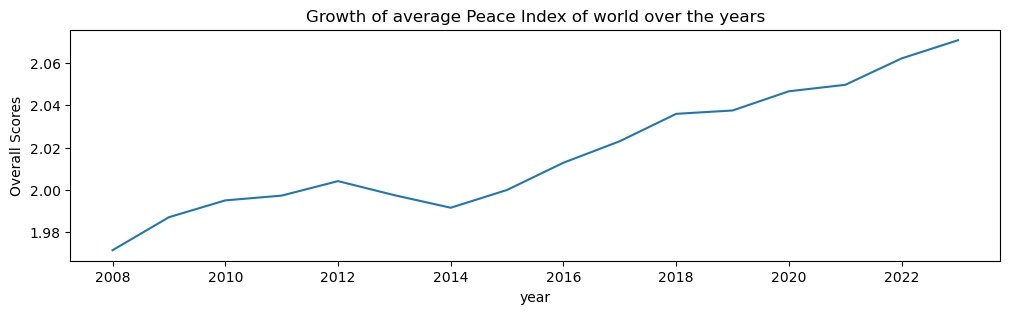

In [32]:
plt.figure(figsize=(12,3))
sns.lineplot(x ='year',y = 'Overall Scores', data =df_peace.groupby('year')['Overall Scores'].mean().reset_index())
plt.title("Growth of average Peace Index of world over the years")
plt.show()

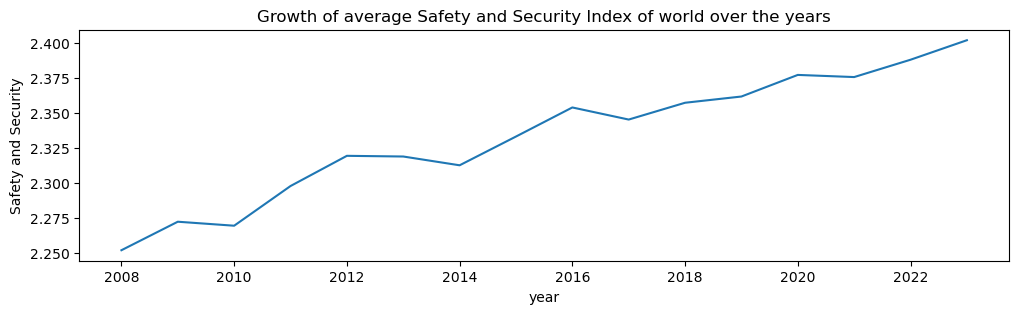

In [33]:
plt.figure(figsize=(12,3))
sns.lineplot(x ='year',y = 'Safety and Security', data =df_peace.groupby('year')['Safety and Security'].mean().reset_index())
plt.title("Growth of average Safety and Security Index of world over the years")
plt.show()

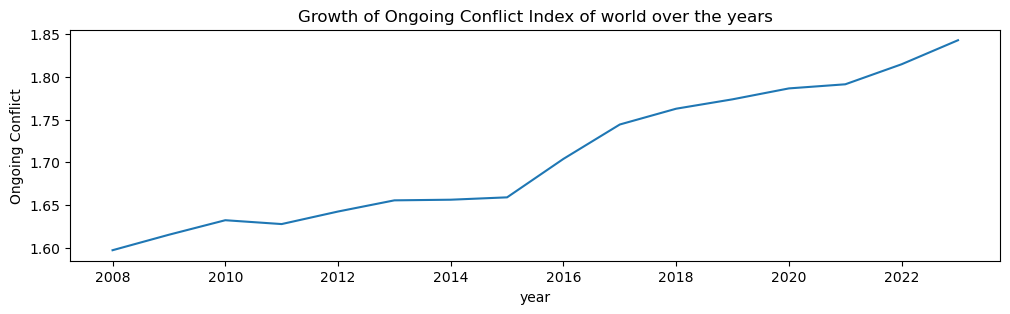

In [34]:
plt.figure(figsize=(12,3))
sns.lineplot(x ='year',y = 'Ongoing Conflict', data =df_peace.groupby('year')['Ongoing Conflict'].mean().reset_index())
plt.title("Growth of Ongoing Conflict Index of world over the years")
plt.show()

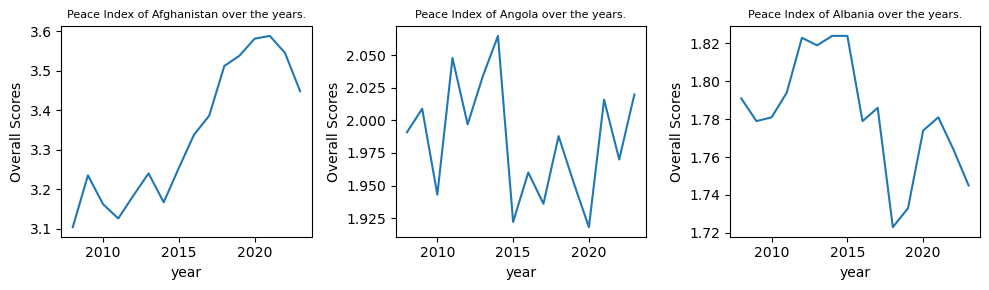

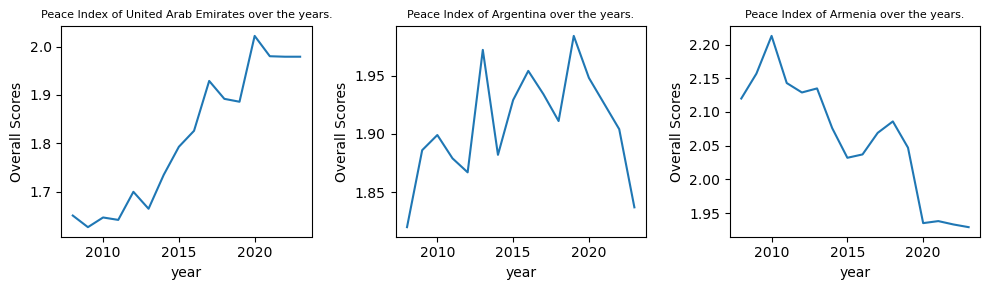

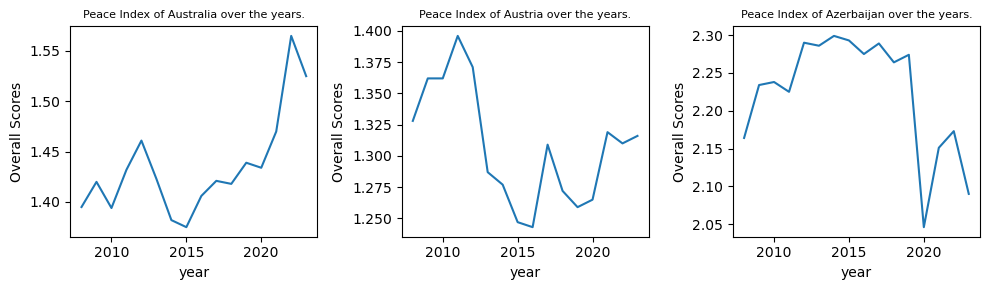

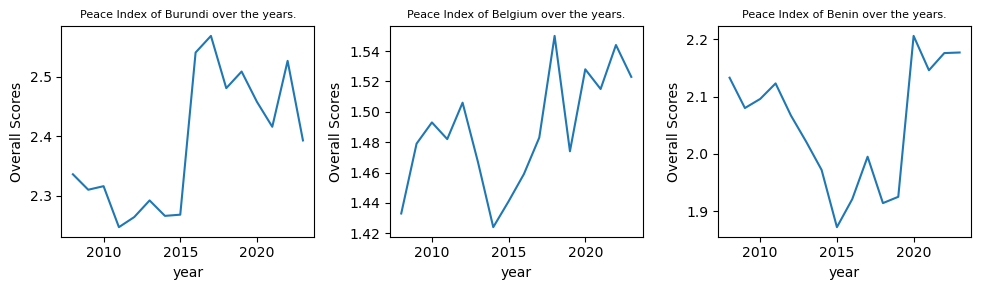

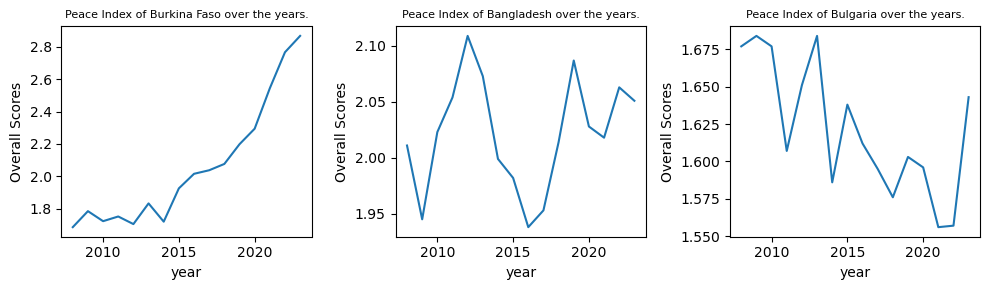

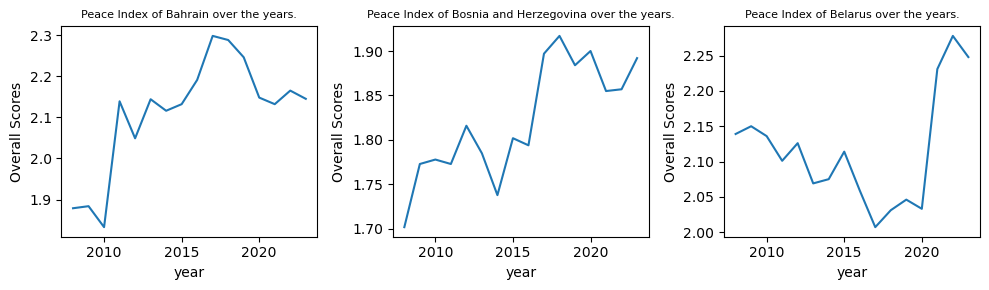

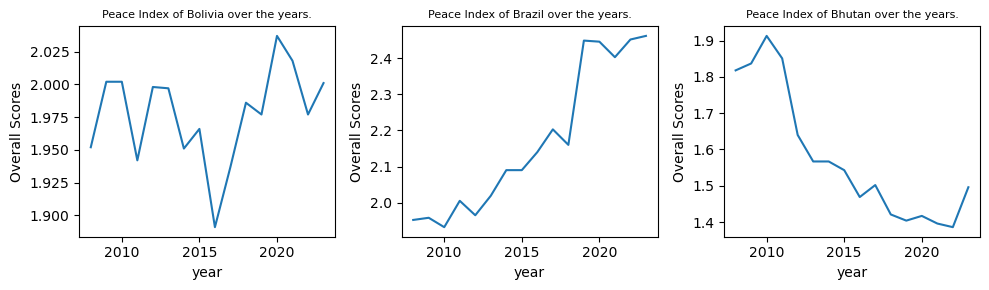

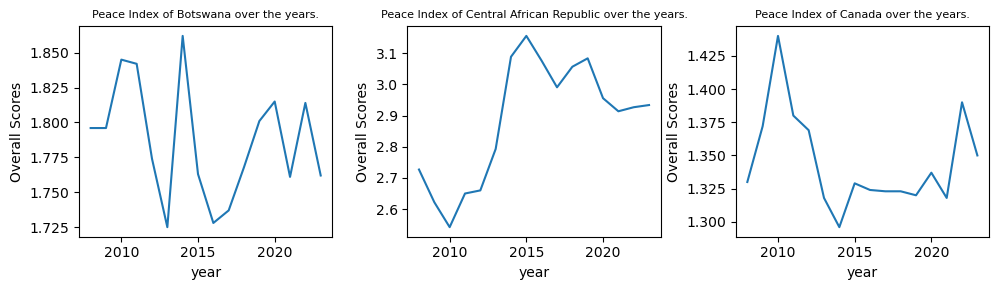

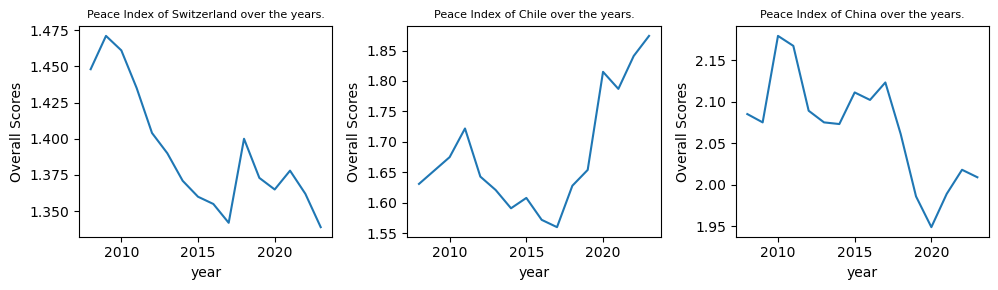

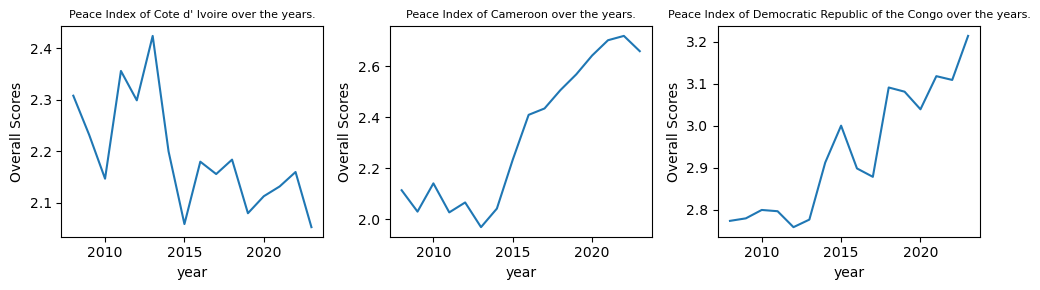

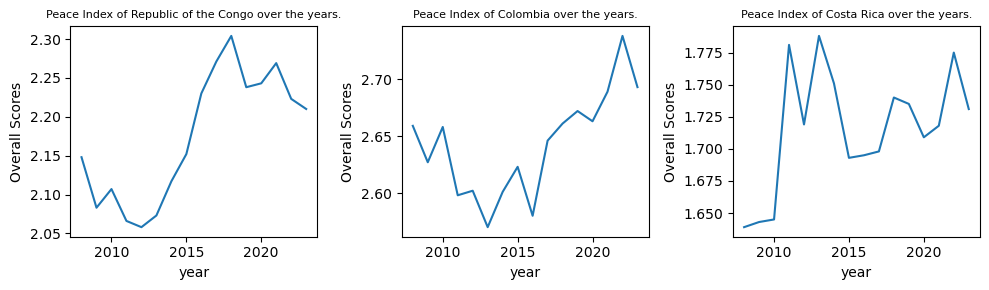

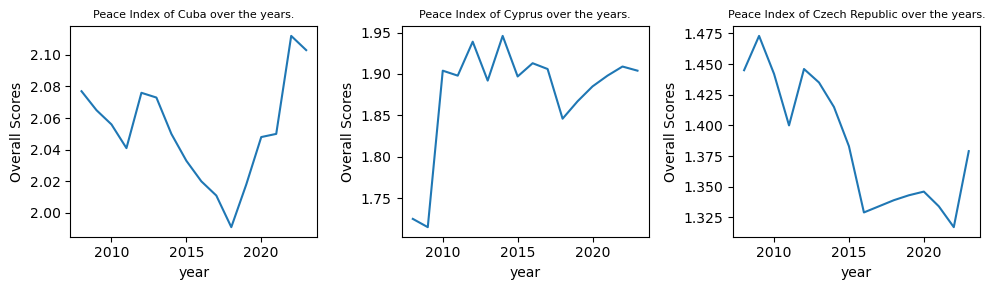

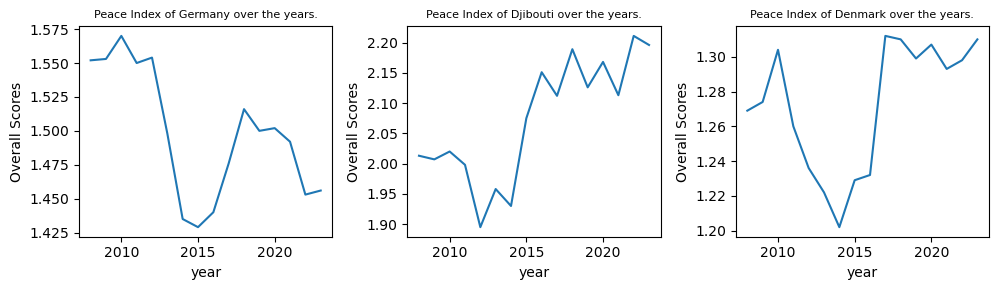

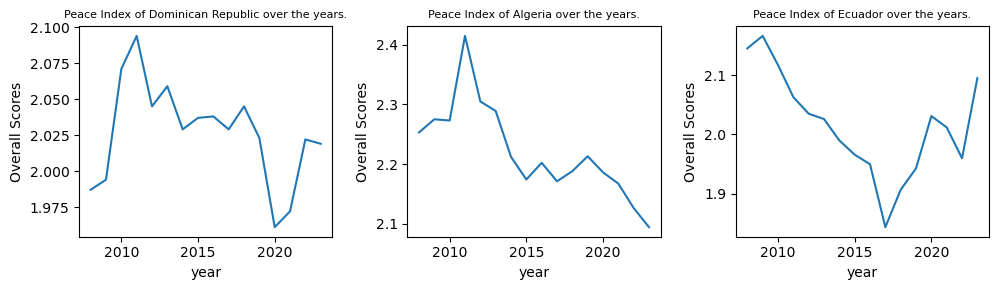

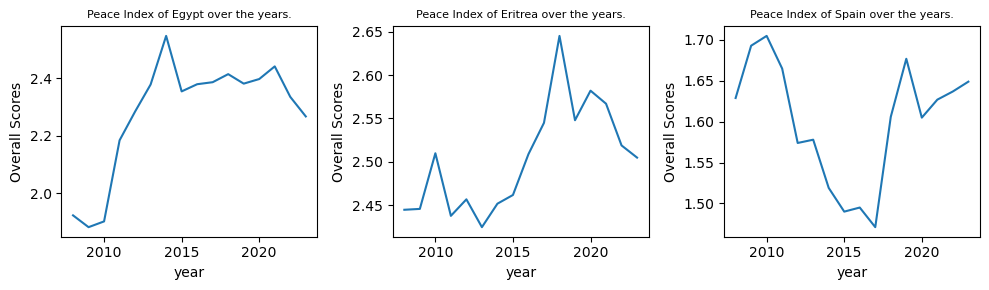

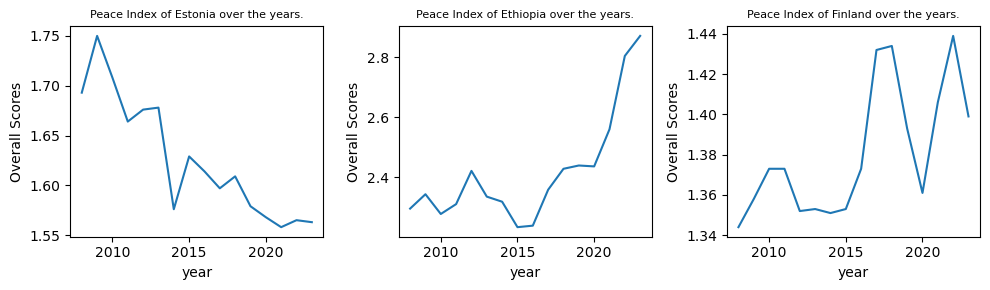

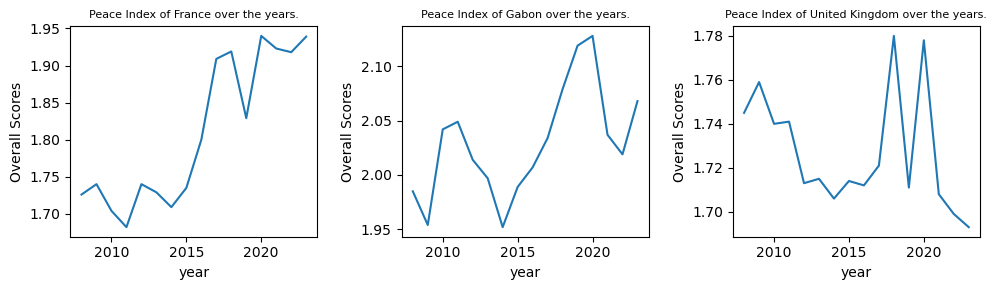

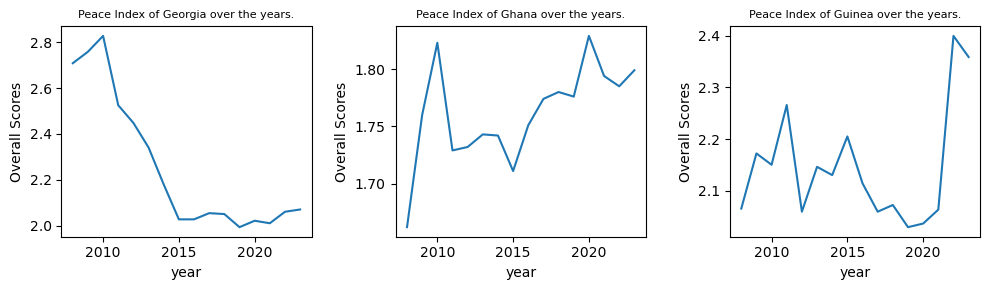

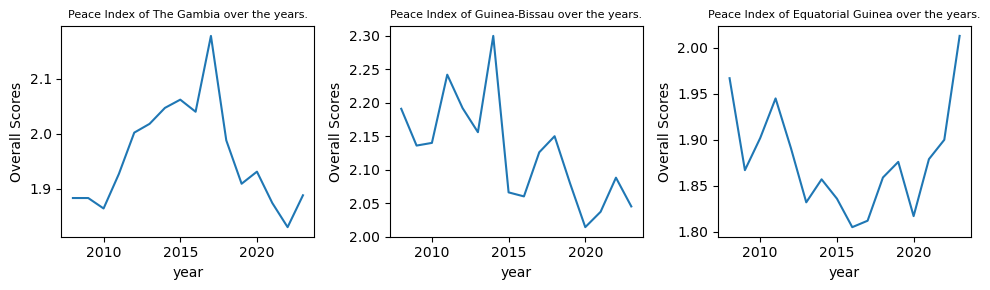

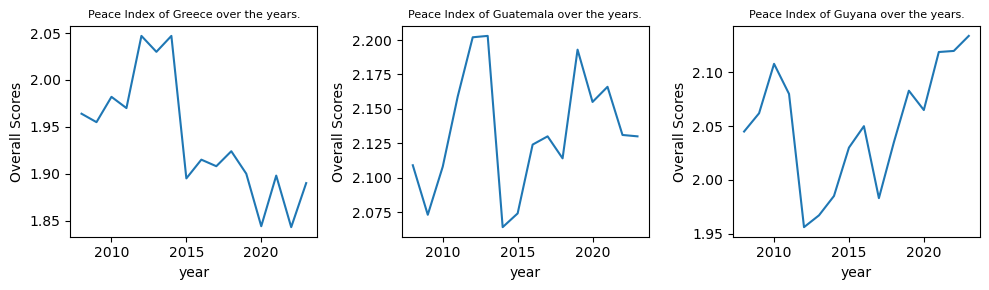

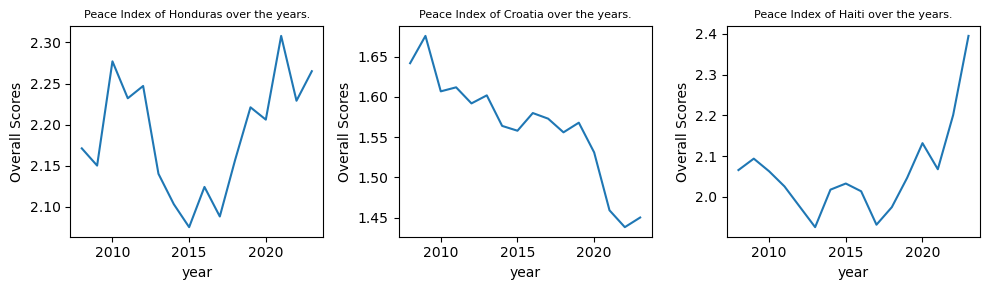

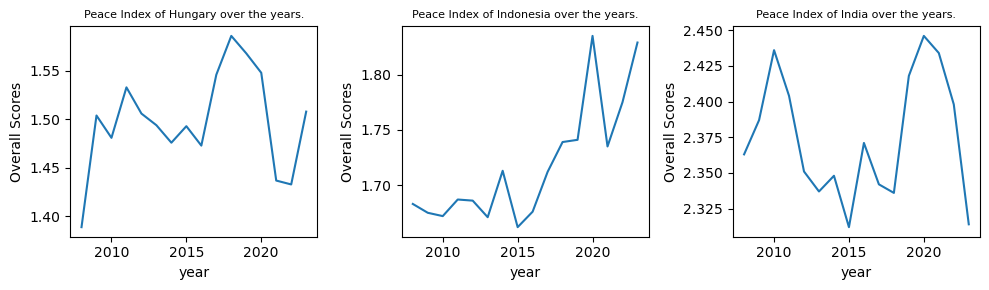

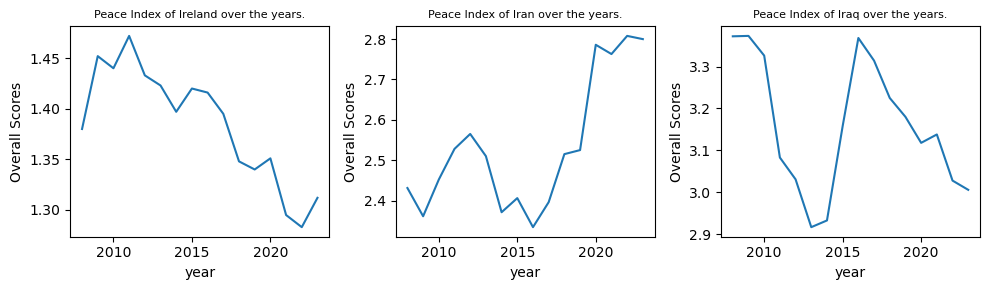

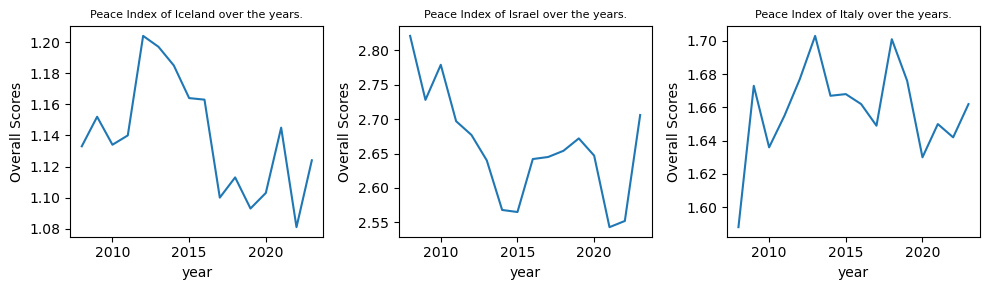

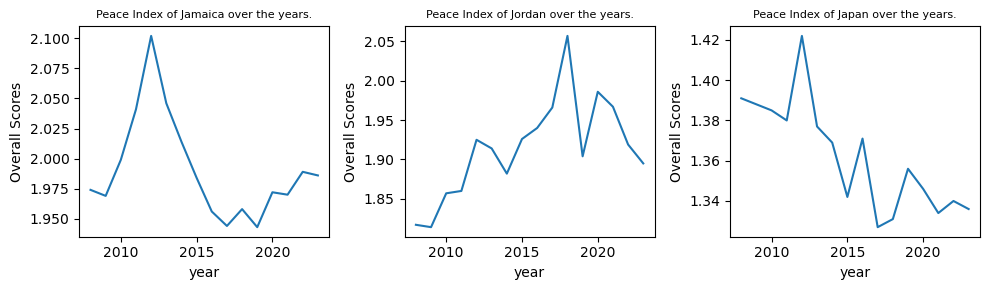

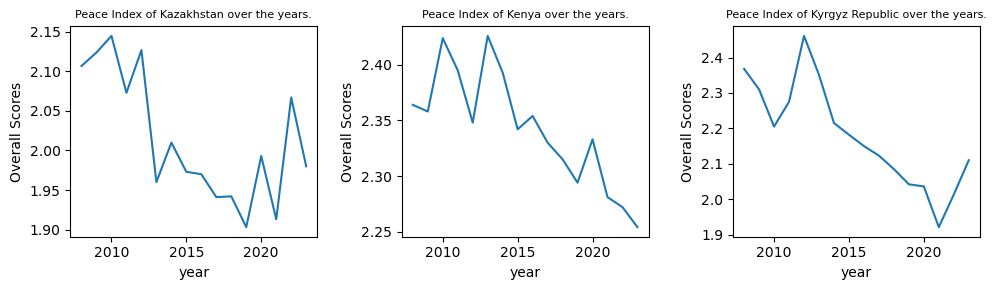

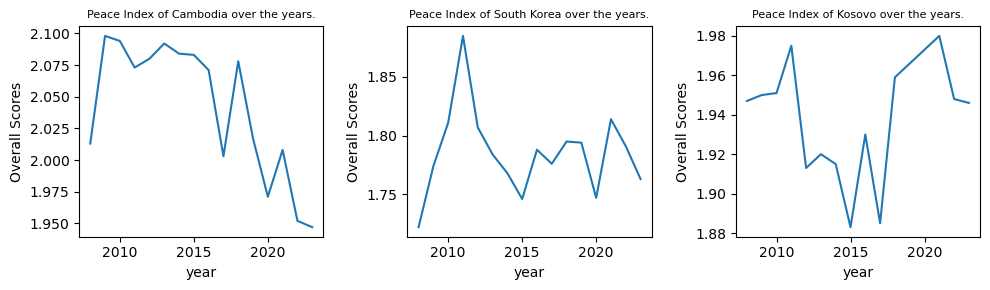

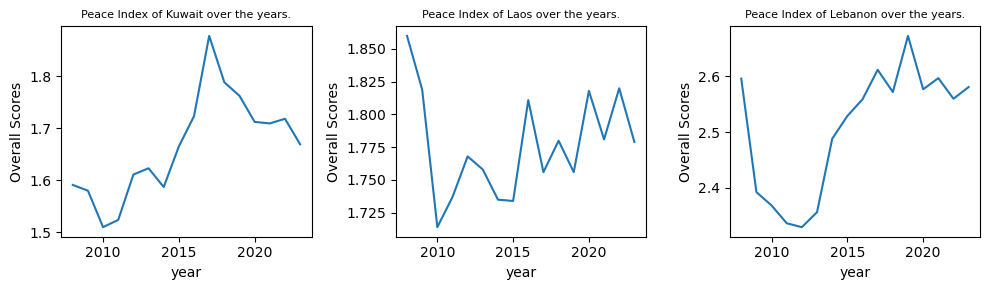

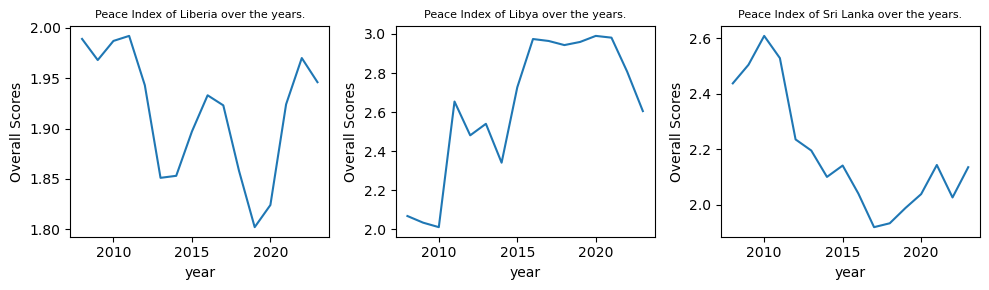

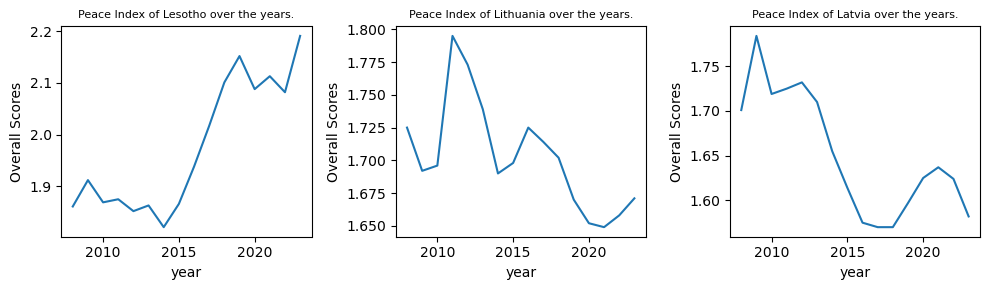

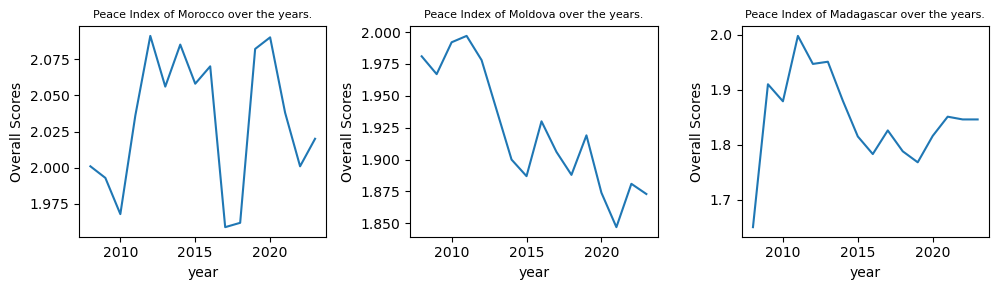

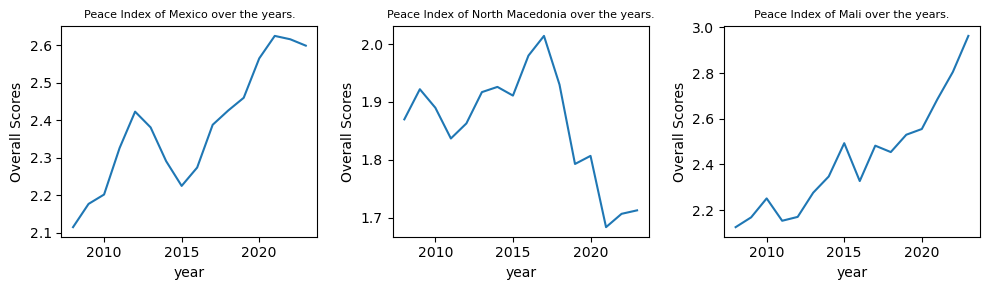

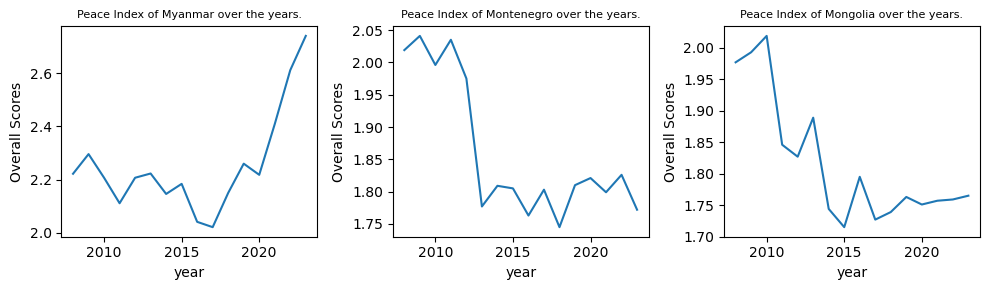

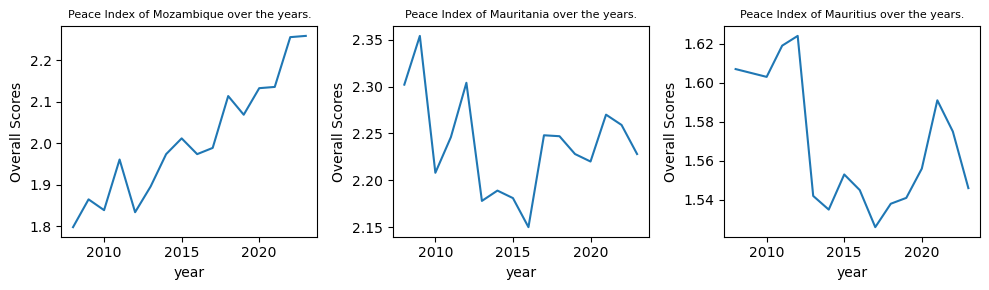

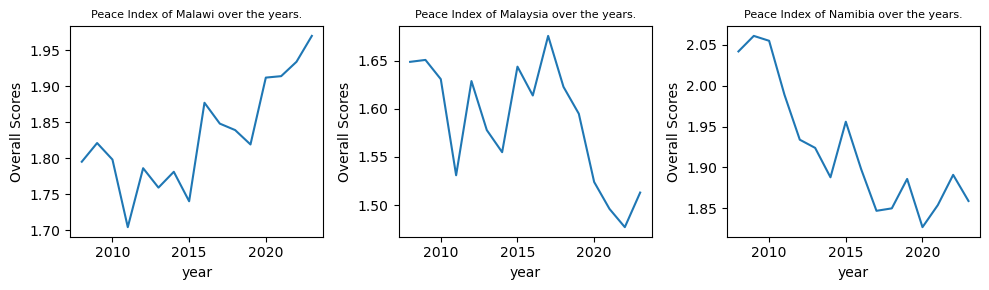

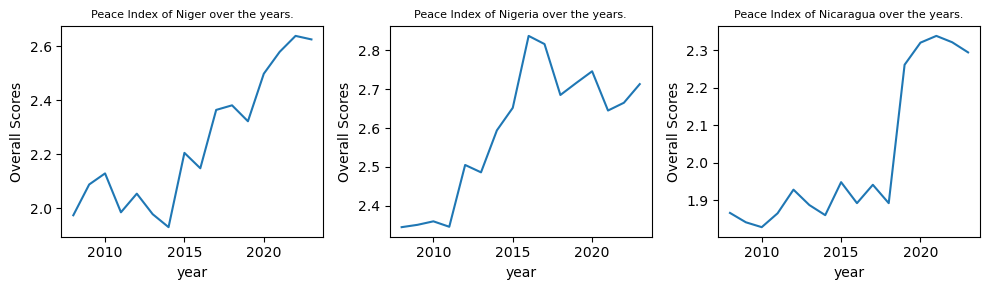

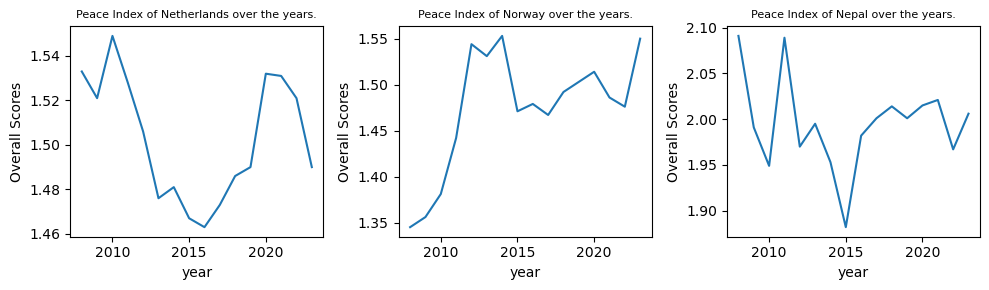

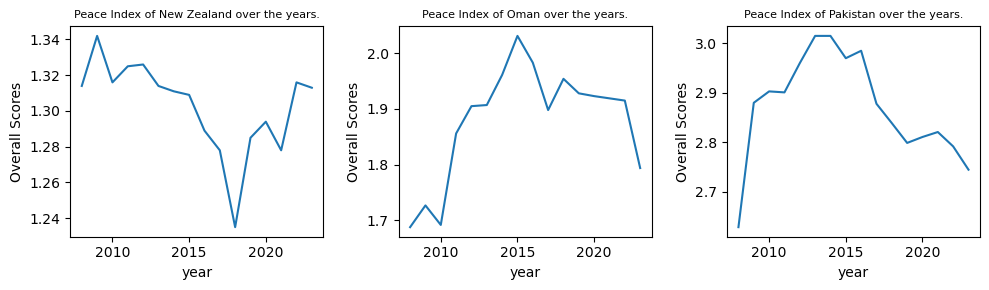

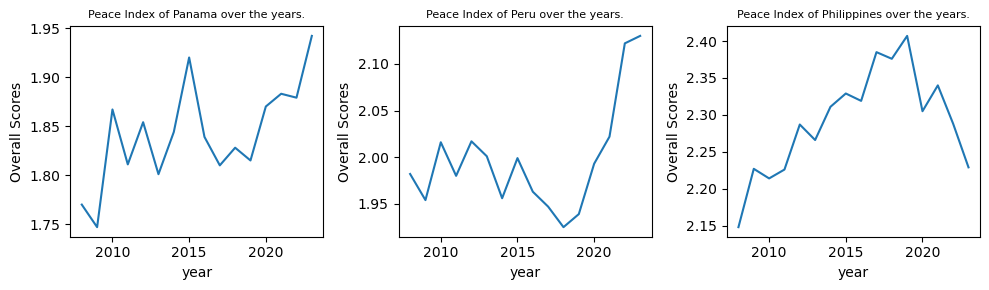

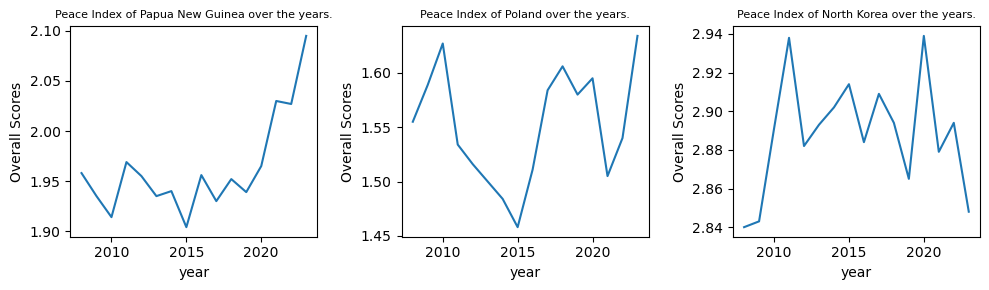

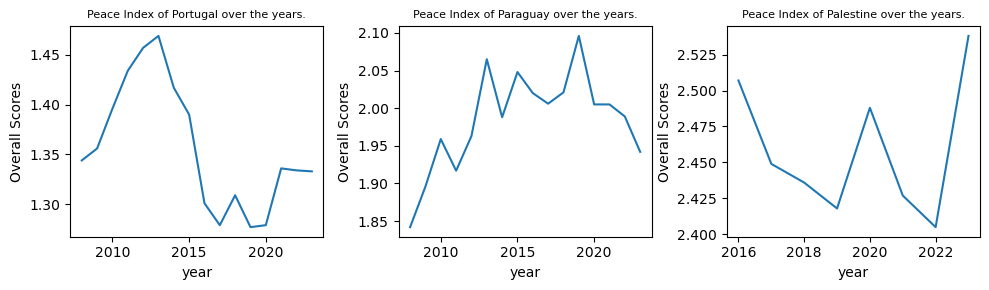

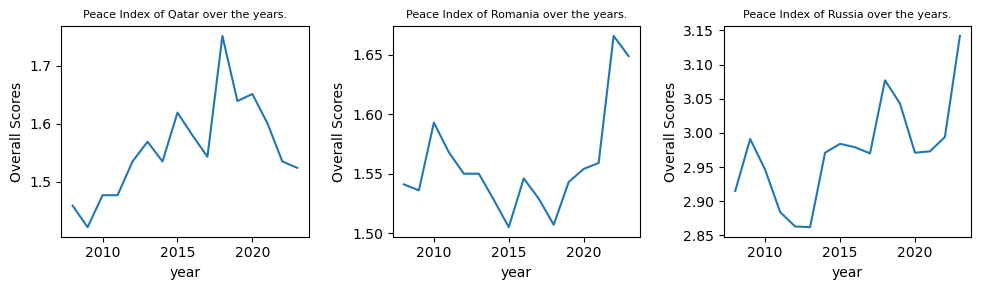

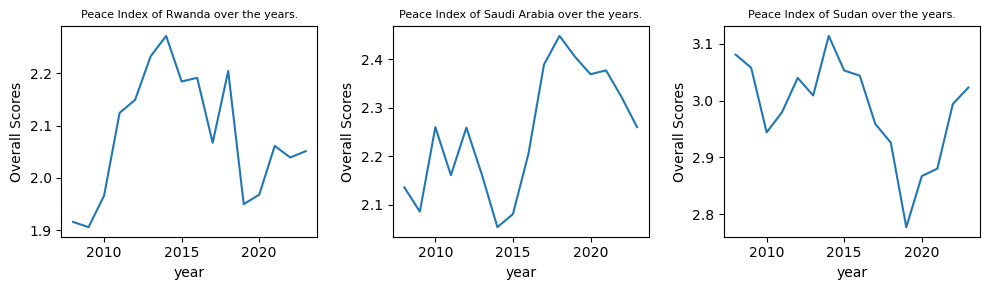

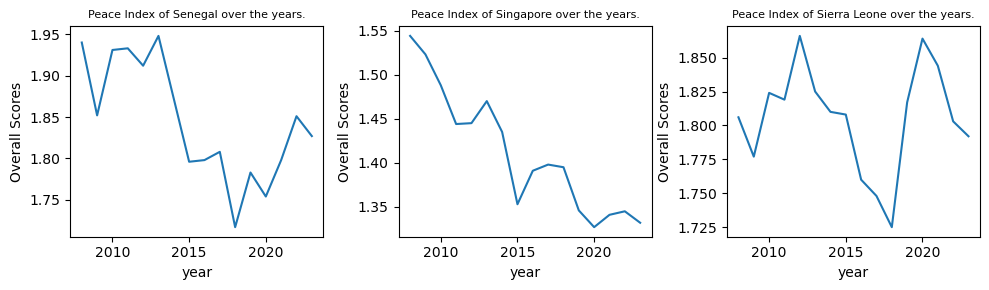

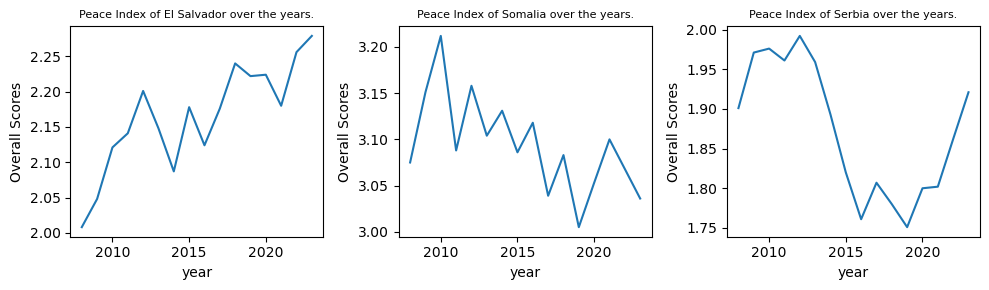

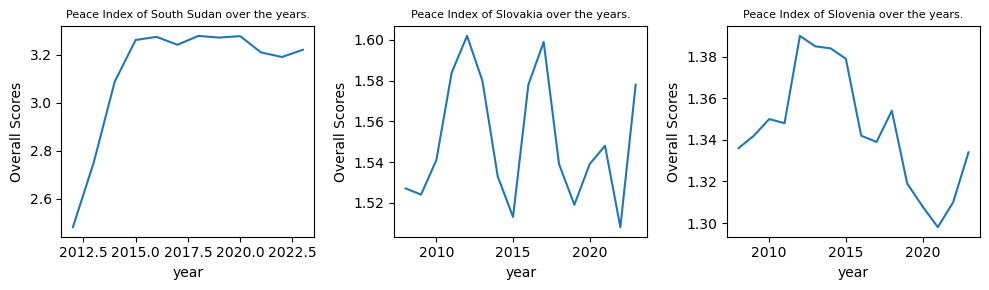

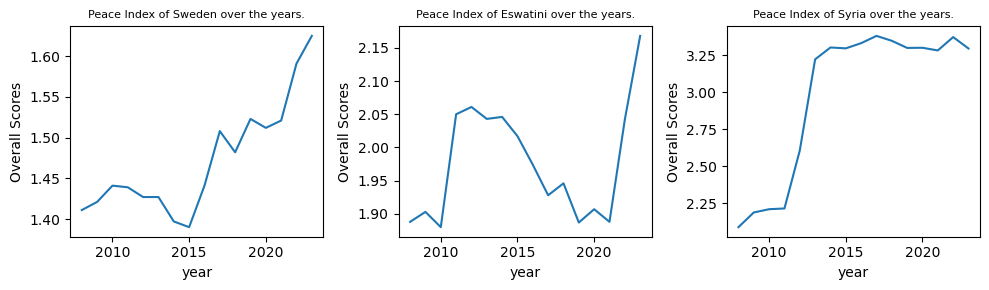

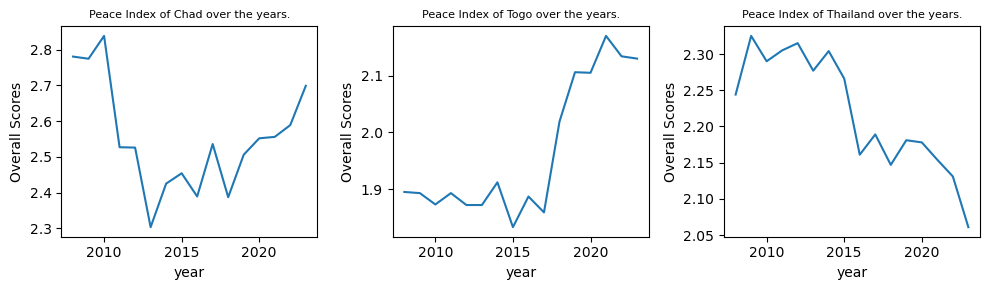

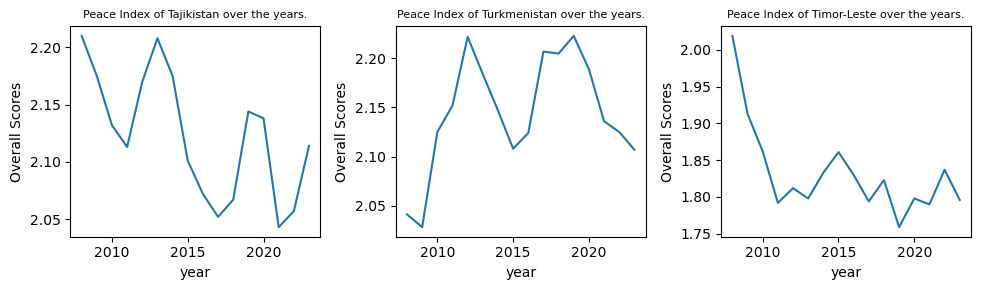

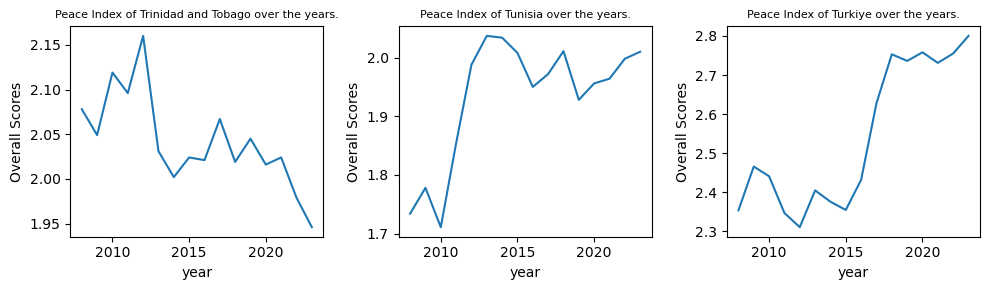

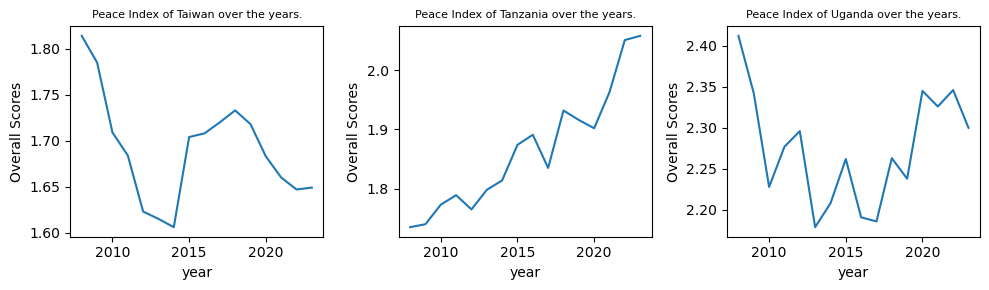

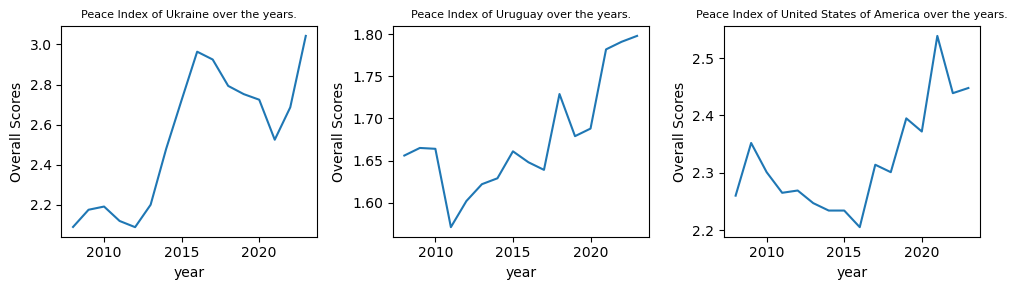

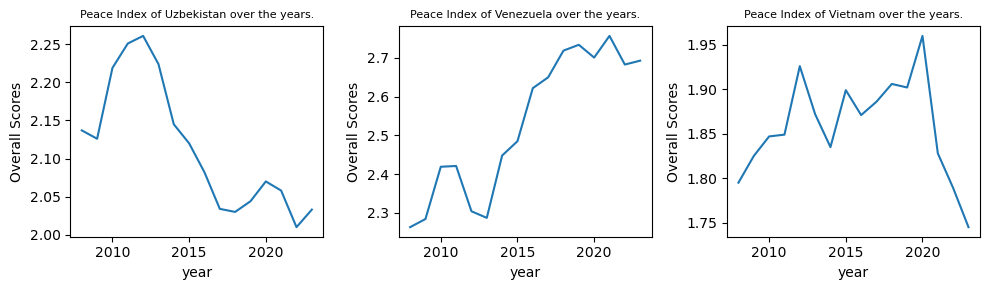

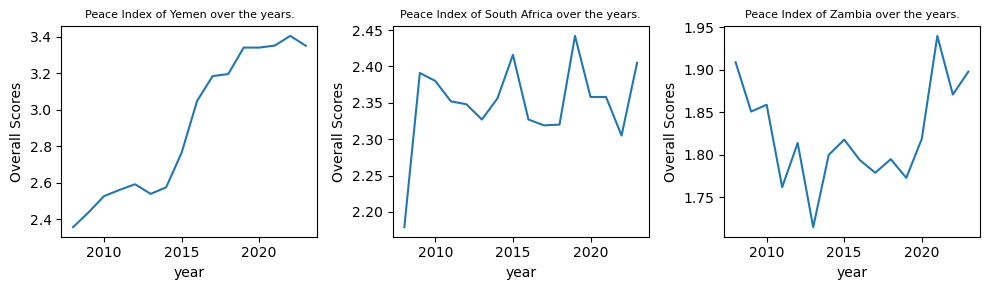

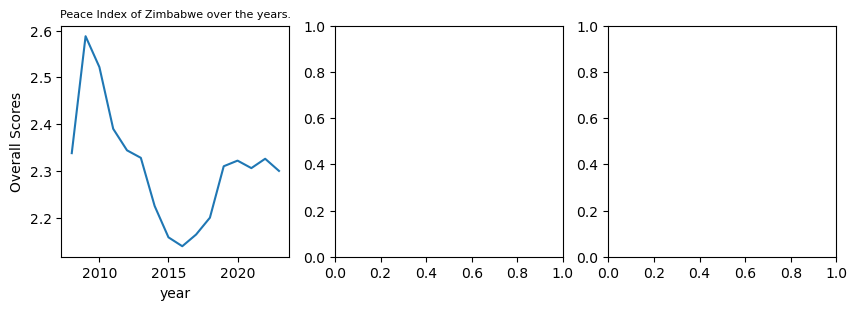

In [35]:
x = df_peace['Country'].unique()
count = 0

fig, axes = plt.subplots(1,3, figsize=(10, 3))
for i in x :
    if count == 3:
        count = 0
        plt.tight_layout()
        plt.show()
        print("\n\n")
        fig, axes = plt.subplots(1,3, figsize=(10, 3))
    loop_df = df_peace[df_peace['Country'] == i][['year','Overall Scores']]
    sns.lineplot(x='year', y ='Overall Scores', data=loop_df, ax=axes[count])
    axes[count].set_title(f'Peace Index of {i} over the years.',fontsize=8)
    count+=1